# 🔧 Temel kütüphanelerin içe aktarılması

In [10]:
import numpy as np                  # Sayısal işlemler için (array, matris vb.)
import pandas as pd                 # Veri analizi ve DataFrame işlemleri için
import matplotlib.pyplot as plt     # Grafik ve görselleştirme için

# 📚 Veri seti ve ön işleme araçları (scikit-learn)
from sklearn.datasets import fetch_20newsgroups       # 20 farklı haber grubundan oluşan metin veri seti
from sklearn.preprocessing import LabelEncoder        # Etiketleri sayısal değerlere dönüştürmek için
from sklearn.model_selection import train_test_split  # Eğitim/test veri setlerini ayırmak için

# 🧠 Derin öğrenme veri ön işleme ve model katmanları (Keras)
from tensorflow.keras.preprocessing.text import Tokenizer        # Metinleri sayısal verilere dönüştürmek için
from tensorflow.keras.preprocessing.sequence import pad_sequences # Dizi uzunluklarını eşitlemek için
from tensorflow.keras.models import Sequential                   # Katmanları sıralı şekilde tanımlamak için
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM  # Modelin katmanları
from tensorflow.keras.callbacks import EarlyStopping             # Aşırı öğrenmeyi önlemek için erken durdurma
from tensorflow.keras.regularizers import l2               # L2 regularizasyonu: büyük ağırlıkları cezalandırarak modelin aşırı öğrenmesini önler 
                                                                                                                      # (Ridge Regression benzeri)

# 🚫 Uyarıları önlemek için
import warnings
warnings.filterwarnings("ignore")  # Gereksiz uyarı mesajlarını önler

# 📥 20 Newsgroups veri setinin yüklenmesi & veri ön işleme aşaması

In [21]:
newsgroup = fetch_20newsgroups(subset="all")  # "all" seçilerek hem eğitim hem test verileri birlikte yükleniyor

# 🧾 Özellik ve hedef değişkenlerin ayrılması
X, y = newsgroup.data, newsgroup.target       # X: metinler, y: kategorik etiketler

# 🧠 Metinleri sayısal verilere dönüştürme işlemi
tokenizer = Tokenizer(num_words=15000)        # En sık geçen 15.000 kelime dikkate alınacak
tokenizer.fit_on_texts(X)                     # Tokenizer, tüm metin verisiyle eğitilir (sözlük oluşturur)
X_sequences = tokenizer.texts_to_sequences(X) # Her metni, kelime indekslerinden oluşan bir diziye çevirir
X_padded = pad_sequences(X_sequences, maxlen=100)  # Tüm diziler sabit uzunlukta (100) olacak şekilde pad edilir

# 🎯 Etiketleri sayısal formata dönüştürme
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)    # Metin sınıf etiketlerini 0'dan başlayan sayılara dönüştürür

# ✂️ Eğitim ve test verisinin ayrılması
x_train, x_test, y_train, y_test = train_test_split(X_padded, y_encoded, test_size=0.25, random_state=32)  # %80 eğitim - %25 test oranıyla veri ayrılır

# 🔧 LSTM tabanlı modelin inşası

In [24]:
def build_lstm_model():
    model = Sequential()

    # 🔠 Embedding katmanı:
    # 10.000 kelimelik bir kelime dağarcığı ile her kelime 64 boyutlu vektöre gömülüyor.
    # Giriş boyutu sabit: 100 (önceki padding işlemiyle belirlenmişti)
    model.add(Embedding(input_dim=15000, output_dim=32, input_shape=(100,)))

    # 🧠 LSTM katmanı:
    # 64 hücreli LSTM katmanı; sıradaki kelimeleri öğrenmek için kullanılır
    model.add(LSTM(units=32, return_sequences=False))

    # 🔻 Dropout katmanı:
    # Aşırı öğrenmeyi (overfitting) önlemek için %50 oranında nöron devre dışı bırakılır
    model.add(Dropout(0.6))

    # 🎯 Çıkış katmanı:
    # 20 sınıflı çok sınıflı sınıflandırma problemi olduğu için softmax aktivasyonu kullanılır
    model.add(Dense(20, activation="softmax", kernel_regularizer = l2(0.01)))

    # ⚙️ Modelin derlenmesi:
    # sparse_categorical_crossentropy → integer (etiket) kullanıldığı için doğru loss fonksiyonu
    model.compile(
        optimizer="adam", 
        loss="sparse_categorical_crossentropy", 
        metrics=["accuracy"]
    )

    return model

# 📦 Model örneği oluşturuluyor
model = build_lstm_model()

# 🧾 Modelin özet yapısını görüntüleme
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 100, 32)        │       480,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 20)             │           660 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 488,980 (1.87 MB)

 Trainable params: 488,980 (1.87 MB)

 Non-trainable params: 0 (0.00 B)

# Model train & evaluate

In [25]:
# ⏹️ EarlyStopping Callbacks:
# Eğitim sırasında doğrulama kaybı (val_loss) 5 epoch boyunca iyileşmezse eğitim durdurulur.
# Ayrıca en iyi ağırlıklar geri yüklenir (overfitting'e karşı koruma sağlar).
early_stopping = EarlyStopping(
    monitor="val_loss", 
    patience=7, 
    restore_best_weights=True
)

# 🚀 Modelin eğitilmesi:
# Eğitim verisi üzerinden 20 epoch boyunca çalışır.
# Doğrulama verisi olarak eğitim setinin %20'si kullanılır.
# Early stopping ile en iyi model korunur.
history = model.fit(
    x_train, 
    y_train, 
    epochs=20, 
    batch_size=16, 
    validation_split=0.25, 
    callbacks=[early_stopping]
)

# 📊 Eğitim geçmişi dictionary formatında saklanır
history = history.history

# 🧪 Modelin test verisi üzerindeki performansının değerlendirilmesi
loss, accuracy = model.evaluate(x_test, y_test)
print(f"Test loss: {loss:.2f}, Test accuracy: {accuracy:.2f}")

Epoch 1/20
663/663 ━━━━━━━━━━━━━━━━━━━━ 32s 42ms/step - accuracy: 0.0728 - loss: 3.0603 - val_accuracy: 0.1072 - val_loss: 2.8742
Epoch 2/20
663/663 ━━━━━━━━━━━━━━━━━━━━ 29s 44ms/step - accuracy: 0.1041 - loss: 2.8144 - val_accuracy: 0.1186 - val_loss: 2.6602
Epoch 3/20
663/663 ━━━━━━━━━━━━━━━━━━━━ 28s 42ms/step - accuracy: 0.1374 - loss: 2.5867 - val_accuracy: 0.1508 - val_loss: 2.6531
Epoch 4/20
663/663 ━━━━━━━━━━━━━━━━━━━━ 28s 43ms/step - accuracy: 0.1856 - loss: 2.4960 - val_accuracy: 0.2018 - val_loss: 2.3906
Epoch 5/20
663/663 ━━━━━━━━━━━━━━━━━━━━ 25s 38ms/step - accuracy: 0.2327 - loss: 2.3156 - val_accuracy: 0.2329 - val_loss: 2.3674
Epoch 6/20
663/663 ━━━━━━━━━━━━━━━━━━━━ 27s 41ms/step - accuracy: 0.2648 - loss: 2.2445 - val_accuracy: 0.2091 - val_loss: 2.5623
Epoch 7/20
663/663 ━━━━━━━━━━━━━━━━━━━━ 28s 42ms/step - accuracy: 0.2397 - loss: 2.3275 - val_accuracy: 0.2934 - val_loss: 2.2584
Epoch 8/20
663/663 ━━━━━━━━━━━━━━━━━━━━ 26s 39ms/step - accuracy: 0.3305 - loss: 2.0500 - 

# 📊 Eğitim sürecinin görselleştirilmesi

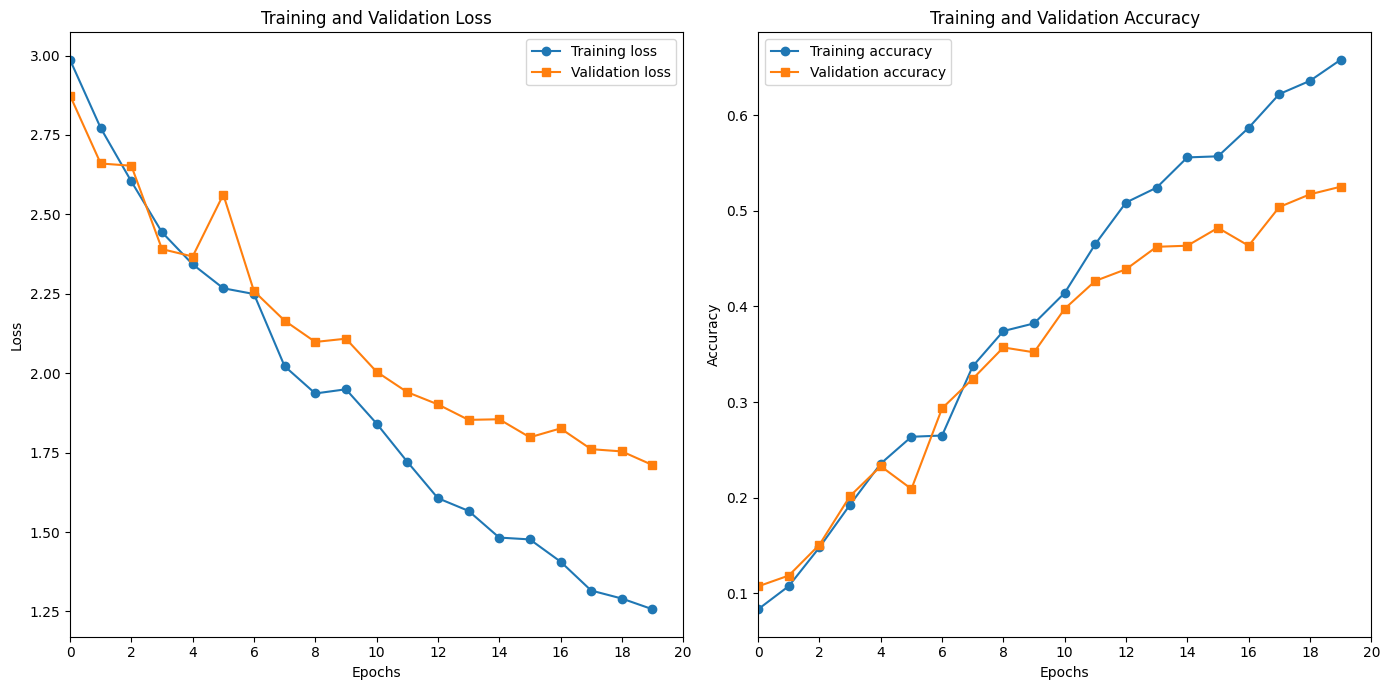

In [39]:
import matplotlib.ticker as ticker

# Hem eğitim hem doğrulama verisi üzerindeki loss ve accuracy değişimi gösterilir.
fig, ax = plt.subplots(1, 2, figsize=(14, 7))

# 🔻 Loss grafiği
ax[0].plot(history["loss"], "o-", label="Training loss")
ax[0].plot(history["val_loss"], "s-", label="Validation loss")
ax[0].set_title("Training and Validation Loss")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[0].set_xlim([0,20])
ax[0].legend()

# Yalnızca integer gösterim ayarları
ax[0].xaxis.set_major_locator(ticker.MaxNLocator(integer=True))


# 🔺 Accuracy grafiği
ax[1].plot(history["accuracy"], "o-", label="Training accuracy")
ax[1].plot(history["val_accuracy"], "s-", label="Validation accuracy")
ax[1].set_title("Training and Validation Accuracy")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
ax[1].set_xlim([0,20])
ax[1].legend()
# Yalnızca integer gösterim ayarları
ax[1].xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

plt.tight_layout()
plt.show()